<a href="https://colab.research.google.com/github/ParthJain18/power-cosumption-chatbot/blob/main/energy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and loading the dataset

In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-09 09:03:25--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [   <=>              ]  19.68M  36.6MB/s    in 0.5s    

2025-06-09 09:03:29 (36.6 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
import pandas as pd

df = pd.read_csv('household_power_consumption.txt',
                sep=';',
                na_values=['?'],
                low_memory=False)

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(['Date', 'Time'], axis=1)

df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

df.columns = df.columns.str.lower()

# df = df.set_index('datetime_index')

<ipython-input-2-41a6a4dee4db>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Global_active_power'] = df['Global_active_power'].astype(float)


In [ ]:
df

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00


# Initializing LLM

In [ ]:
!pip install -qU "langchain[groq]"
!pip install -qU langchain-google-genai

In [ ]:
LLM_PROVIDER = "gemini" # "groq" or "gemini"

import getpass
import os

try:
  from google.colab import userdata
  if LLM_PROVIDER == "groq":
      os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
  elif LLM_PROVIDER == "gemini":
      os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except Exception:
  pass

if LLM_PROVIDER == "groq" and not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter Groq API key: ")

elif LLM_PROVIDER == "gemini" and not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter Gemini API key: ")

if LLM_PROVIDER == "groq":
  from langchain.chat_models import init_chat_model
  llm = init_chat_model("meta-llama/llama-4-maverick-17b-128e-instruct", model_provider="groq")

elif LLM_PROVIDER == "gemini":
  from langchain_google_genai import ChatGoogleGenerativeAI
  llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

else:
  raise ValueError("Unsupported LLM_PROVIDER. Use 'groq' or 'gemini'.")

# Custom Pandas tool

In [ ]:
from langchain_core.tools import tool
import numpy as np

In [ ]:
from typing import Optional

from pydantic import BaseModel, Field

class PandasReponseFormat(BaseModel):
  thoughts: str = Field(description="The thoughts before writing the pandas query")
  code: str = Field(description="The required pandas query")

pandas_llm = llm.with_structured_output(PandasReponseFormat)

In [ ]:
import matplotlib.pyplot as plt
import os
import uuid

In [ ]:
@tool
def create_and_execute_pandas_query(question: str) -> str:
  """
  Generates and safely executes a Pandas query using an LLM and returns the result as a string. Only has access to the DataFrame 'df', that has details about Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.
  Don't use this tool if the question is not related to the electric power consumption dataframe.
  If it returned an error and you see a fix, try to include that instruction in the question as well.
  It can also generate graphs using matplotlib.pyplot.

  Input:
  question: str - A natural language question about the electric power consumption dataframe.

  Output:
  str - The result of the Pandas query as a string.
  """

  prompt = f"""
  You are a helpful assistant that converts natural language questions into **one-line executable Pandas code**.
  Use the DataFrame `df`. Only use pandas operations — no imports, no built-ins.

  Guidelines:
  - Think before coding. Ensure the output is correct and efficient.
  - Try to find summary type data like count, average etc. instead of returning rows upon rows of the df.
  - NEVER return more than 10-20 rows of the df.
  - If the question can't be answered via the DataFrame, return a single Python comment explaining the logic.
  - `global_active_power` is in **kilowatts (kW)** and sampled **every minute**.
    - This represents instantaneous power, not energy.
    - If a question uses terms like "energy", "consumption", or "usage", interpret it as **total energy in kilowatt-hours (kWh)**.
        - Compute this by resampling (e.g., daily) and using: `(global_active_power.sum() / 60)`
    - Only use `.mean()` if the question clearly asks for "average power", not "energy" or "usage".
  - Aggregate before filtering. For summaries over days/months/years, use `groupby(df['datetime'].dt.<unit>)` or `resample('<unit>', on='datetime')`.
  - Do not use per-minute data for daily or higher-level summaries.
  - For potentially large outputs, return only `.head(10)` or a summary.
  - Assign your result to the variable `output`.
  - You may also generate matplotlib plots (e.g., df.plot(...)) and assign the plot object to `output`.
  - Do NOT call `plt.show()`, just assign the plot to `output = df.plot(...)` or similar.


  The DataFrame has these columns:
  - `datetime`: datetime64[ns] (%d/%m/%Y %H:%M:%S)
  - `global_active_power`: float (kW)
  - `global_reactive_power`: float
  - `voltage`: float
  - `global_intensity`: float
  - `sub_metering_1`: int (Wh)
  - `sub_metering_2`: int (Wh)
  - `sub_metering_3`: int (Wh)

  Examples:

  Q: What is the average global active power in March 2007?
  A: result = df[df['datetime'].dt.month == 3 & (df['datetime'].dt.year == 2007)]['global_active_power'].mean()


  Question: {question}
  """
  try:
    result = pandas_llm.invoke(prompt)
    code = result.code

    unsafe_keywords = ['import', 'open', 'os.', 'sys.', 'subprocess', '__', 'exec', 'eval']
    if any(keyword in code for keyword in unsafe_keywords):
      raise ValueError("Unsafe code detected in generated code.")

    print(f"[Generated Code]: {code}")

    safe_globals = {"__builtins__": {}}
    safe_locals = {"df": df.copy(), "pd": pd, "plt": plt}

    exec(code, safe_globals, safe_locals)

    output = safe_locals.get("output", None)
    output_str = ""

    if output is None:
      output_str = "No output was generated."

    elif isinstance(output, (pd.DataFrame, pd.Series)):
      if len(output) > 10:
        output = output.head(10)
        truncated = True
      else:
        truncated = False
      output_str = output.to_string(index=False)
      if truncated:
        output_str += '\n... [truncated]'

    elif hasattr(output, "figure"):
      filename = f"plot_{uuid.uuid4().hex[:8]}.png"
      output.figure.savefig(filename)

      from IPython.display import Image, display
      display(Image(filename))

      plt.close(output.figure)
      output_str = f"[Plot saved as '{filename}']. Please open this file to view the plot."

    else:
      output_str = str(output)

    if len(output_str) > 500:
      output_str = output_str[:500] + '\n... [output truncated due to length]'
    return f"Code generated: {code} \nOutput: {output_str}"

  except Exception as e:
    return f"Error: {str(e)}"

## Testing the tool

[Generated Code]: output = df[df['datetime'].dt.year == 2007].groupby(df['datetime'].dt.month)['global_active_power'].mean().plot()


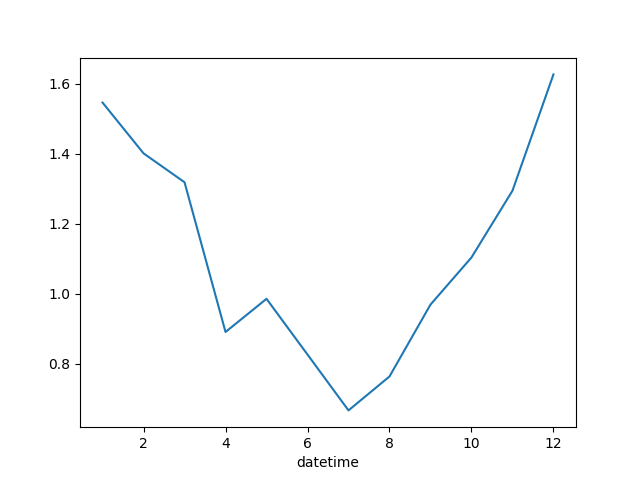

Code generated: output = df[df['datetime'].dt.year == 2007].groupby(df['datetime'].dt.month)['global_active_power'].mean().plot() 
Output: [Plot saved as 'plot_04d8aec4.png']. Please open this file to view the plot.


In [ ]:
print(create_and_execute_pandas_query.invoke("What was the average active power consumption in 2007? Can you plot it by months?"))

# LangGraph agent

In [ ]:
!pip install --upgrade --quiet langgraph langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.0 MB/s eta 0:00:00


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "parth12345"}}

system_message = {
    "role": "user",
    "content": """You are a data analysis assistant. You answer questions about electricity consumption from Individual Household Electric Power Consumption.
It contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

You should verify the generated code, if you find something wrong, you may use the tool again by also providing instructions to fix the issue.
If the tool responded that it added a graph, let the user know where they can find the plot.
Your role is to use the provided tool to satisfy user's query.

Ensure that you include the complete answer to the user's question in the final output, it should answer everything without any details from the previous chains.
If the results are ambiguous, try a different approach for the tool.
"""
}

In [ ]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [create_and_execute_pandas_query], checkpointer=memory)

In [ ]:
input_message = "What hour of the day had the highest power usage on Christmas 2006?"

In [ ]:
for event in agent_executor.stream(
  {"messages": [system_message, {"role": "user", "content": input_message}]},
  stream_mode="values",
  config=config,
):
  event["messages"][-1].pretty_print()

================================ Human Message =================================

What hour of the day had the highest power usage on Christmas 2006?
================================== Ai Message ==================================
Tool Calls:
  create_and_execute_pandas_query (call_97z9)
 Call ID: call_97z9
  Args:
    question: Find the hour with the highest Global_active_power on Christmas 2006 (2006-12-25); first convert Date column to datetime if not already done
[Generated Code]: result = df[df['datetime'].dt.date == pd.to_datetime('2006-12-25').date()].groupby(df['datetime'].dt.hour)['global_active_power'].mean().idxmax()
================================= Tool Message =================================
Name: create_and_execute_pandas_query

Code generated: result = df[df['datetime'].dt.date == pd.to_datetime('2006-12-25').date()].groupby(df['datetime'].dt.hour)['global_active_power'].mean().idxmax() 
Output: 22
================================== Ai Message ========================

# Demo - (Check the second cell for custom questions)

================================ Human Message =================================

What was the average active power consumption in March 2007?
================================== Ai Message ==================================
Tool Calls:
  create_and_execute_pandas_query (3c0be606-5f0b-4c9c-b81d-e91bd31cf384)
 Call ID: 3c0be606-5f0b-4c9c-b81d-e91bd31cf384
  Args:
    question: What was the average of Global_active_power in March 2007?
[Generated Code]: output = df[(df['datetime'].dt.month == 3) & (df['datetime'].dt.year == 2007)]['global_active_power'].mean()
================================= Tool Message =================================
Name: create_and_execute_pandas_query

Code generated: output = df[(df['datetime'].dt.month == 3) & (df['datetime'].dt.year == 2007)]['global_active_power'].mean() 
Output: 1.3186270301754073
================================== Ai Message ==================================

The average active power consumption in March 2007 was 1.319 kW.
================

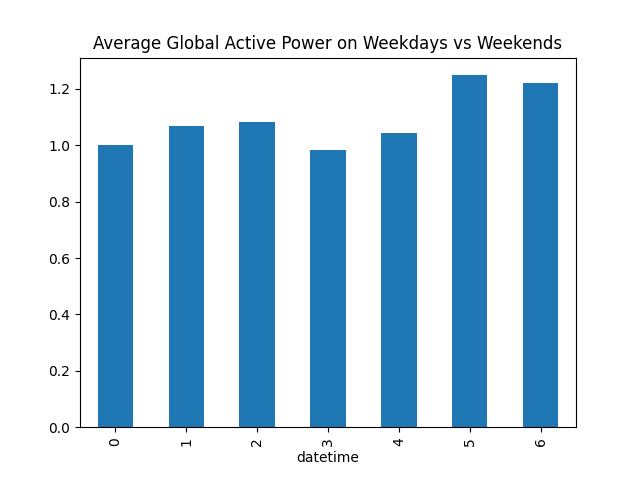

================================= Tool Message =================================
Name: create_and_execute_pandas_query

Code generated: output = df.groupby(df['datetime'].dt.dayofweek)['global_active_power'].mean().plot(kind='bar', title='Average Global Active Power on Weekdays vs Weekends') 
Output: [Plot saved as 'plot_2756d4f3.png']. Please open this file to view the plot.
================================== Ai Message ==================================

The average global active power on weekdays versus weekends has been compared and visualized in a bar graph. You can find the plot in the file named 'plot_2756d4f3.png'.
================================ Human Message =================================

Find days where energy consumption exceeded 5 kWh.
================================== Ai Message ==================================
Tool Calls:
  create_and_execute_pandas_query (15e12801-2c57-4632-929b-f460880d93a3)
 Call ID: 15e12801-2c57-4632-929b-f460880d93a3
  Args:
    question: F

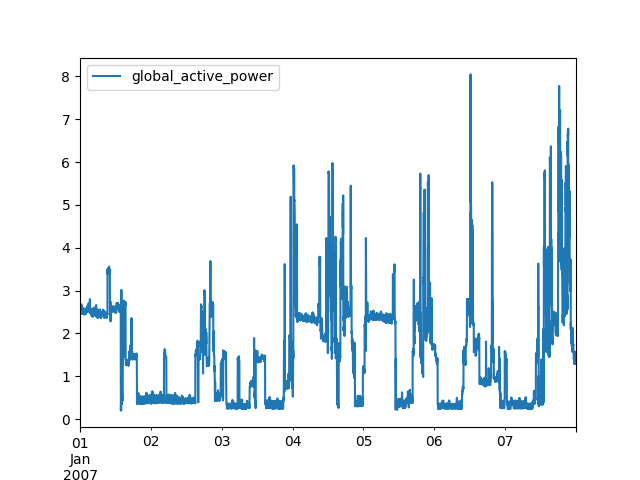

================================= Tool Message =================================
Name: create_and_execute_pandas_query

Code generated: output = df[(df['datetime'].dt.year == 2007) & (df['datetime'].dt.month == 1) & (df['datetime'].dt.day <= 7)].plot(x='datetime', y='global_active_power') 
Output: [Plot saved as 'plot_787f8a51.png']. Please open this file to view the plot.
================================== Ai Message ==================================

The energy usage trend (Global_active_power) for the first week of January 2007 has been plotted and saved to a file named 'plot_787f8a51.png'. You can open this file to view the plot.
================================ Human Message =================================

Find the average voltage for each day of the first week of February 2007.
================================== Ai Message ==================================
Tool Calls:
  create_and_execute_pandas_query (2358c460-7602-4e76-84ea-023d09a54b4f)
 Call ID: 2358c460-7602-4e76-84ea-0

In [ ]:
import time
sample_questions = [
  "What was the average active power consumption in March 2007?",
  "What hour of the day had the highest power usage on Christmas 2006?",
  "Compare energy usage (Global_active_power) on weekdays vs weekends.",
  "Find days where energy consumption exceeded 5 kWh.",
  "Plot the energy usage trend for the first week of January 2007.",
  "Find the average voltage for each day of the first week of February 2007.",
  "What is the correlation between global active power and sub-metering values?"
  ]
i = 0

while i < len(sample_questions):
  user_input = sample_questions[i]
  i += 1

  if user_input.lower() == 'quit':
    print("Goodbye!")
    break

  input_message = user_input
  for event in agent_executor.stream(
    {"messages": [system_message, {"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
  ):
    event["messages"][-1].pretty_print()
  time.sleep(10) #For avoiding rate limits


In [ ]:
while True:
  user_input = input("Chat: ")

  if user_input.lower() == 'quit':
    print("Goodbye!")
    break

  input_message = user_input
  for event in agent_executor.stream(
    {"messages": [system_message, {"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
  ):
    event["messages"][-1].pretty_print()